# 0. Marking and Guidelines
---
***IMPORTANT***

> The **attendance** and **active participation** in the **lab sessions** is **strongly recommended** and will be considered for grading.
>
> Save a copy of this notebook into your Drive before you start
> 
> Please attempt all the **questions** marked for your **group** (Part II ✅ | Part III/MPhil ✅).
> 
> Please, provide your answers in a **new cell below the question cell**. You can make as many new cells as you need.

Please submit a `.zip` file, containing both parts, consisting of:
1. A text file with a **publicly** visible link to your notebooks in GitHub.
2. A **downloaded copy** (`.ipynb`) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report---we will not be re-executing the code you used to produce the answers unless required.


Feel free to attempt more in case you find yourself enjoying the material!
If you have any questions, please ask them to the teaching assistants.
Are you interested in knowing more about federated learning and related topics? Reach out to the teaching assistants for additional resources and ask more about the current research projects.

## 1. Introduction
---

Welcome to the third lab session in our FL course.
We now know how to “federate” a centralised ML model and have learned some tools to deal with data heterogeneity.

During this session, we will try to put our hands on system heterogeneity in simulating FL. However, assuming you want to produce an FL system that will be deployed in the real world, taking into account data heterogeneity is often not enough.

Client hardware may be correlated with the underlying data---e.g. a smartphone's camera impacts image characteristics---or with which data is used. For example, clients with less reliable internet connections from specific regions of the world are more likely to drop out, making their region underrepresented in training. Thus, the limits placed on computation time or the assumptions made in applying a synchronous or asynchronous algorithm affect model performance, fairness, or scalability.

Developers may want to simulate their FL pipelines in a controlled environment in which natural system characteristics are modelled in order to be able to understand such trade-offs.

What should we take into account, then?
Clients' availability, training time, communication bandwidth, and other factors sometimes impact natural FL systems unexpectedly.
Developers usually set up constraints for selecting clients to account for most of these factors, but in the worst case, these may result in not completing even a single round.
On the other hand, relaxing some constraints produces long round completion times, and eventually, the FL model cannot reach convergence in a reasonable interval.

Before we begin modelling such concerns, we shall investigate data regarding real-world system characteristics from the two following papers:

1. [Papaya: Practical, Private, and Scalable Federated Learning](https://arxiv.org/abs/2111.04877)
2. [Towards Federated Learning at Scale: System Design](https://arxiv.org/abs/1902.01046)


## 2. Behavioural patterns of real-world FL systems
---

The following plot was extracted from the Papaya paper (1) mentioned above.
The takeaway is that in natural settings, devices are very heterogeneous, and the same model could take different amounts of time to train on various clients. Since the distribution is neither Gaussian nor uniform, accounting for such behaviour is non-trivial. As a result, developers often have to make imperfect choices when selecting between synchronous and asynchronous FL algorithms and their parameters.


![client_execution_time](../assets/client_execution_time_histo.png)

In the case of synchronous training, they may select clients based on hardware, set time limits for round completion, and incorporate partially trained client models that have not reached the necessary step/epoch count.

Besides tackling the previously discussed data heterogeneity, FedProx was designed to better incorporate partially trained models from stragglers by limiting their impact upon the aggregation. The dual purpose of FedProx illustrates the interdependence of systems and data heterogeneity.

In the case of asynchronous training, all updates **could** be considered; however, model staleness and a significant bias towards faster clients become major issues. For example, clients who return updates based on an older model may have had more data to train on or simply slower internet. If they have more data, they might provide more **statistical utility** than fast clients and thus improve final accuracy. Alternatively, they might have valuable data from underrepresented or remote regions if they have slower internet. If you are curious and want more insights about asynchronous training in FL, we point to the most prominent example: [FedBuf](https://arxiv.org/abs/2106.06639).

In an extreme case of hardware heterogeneity, clients with high-end hardware may guide the model to the detriment of those with better data or those belonging to relevant subgroups. Due to such difficulties, asynchronous FL has been historically more difficult to implement and less preponderantly used than one may expect, given its potential benefits.


---

**Question 7 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. In the context of a complete synchronous FL training period composed of multiple rounds, when do you think it would be appropriate to oversample fast/slow clients? Should it be more appropriate for the early or late training phases? Think of which characteristics are essential for convergence in the early versus late rounds.
2. Can you think of a heuristic for modifying the time threshold across rounds that considers your previous answer?

---


---

**Question 8 (Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. What parallels can be drawn between asynchronous SGD and asynchronous FL? Are there any methods which may help with both?
2. How do you think a system using a buffer to accumulate gradient updates received asynchronously, such as [FedBuf](https://arxiv.org/pdf/2106.06639.pdf), behaves?

---

### 2.1 Cyclical patterns
---

The plot below is taken from paper (2) mentioned above and encapsulates the reliability of client training. In the context of mobile devices, we can observe a cyclic daily trend for each category plotted while the delta between the categories is partly conserved. Thus, according to the number of clients we expect to finish training, we can adapt our training parameters, such as a completion-time threshold.

If the federation included a more diverse set of devices operating in different domains or across a wider geographic area, the number of completing, aborted or dropped-out devices may not show the same synchronised patterns.


![aborted_completed_dropped_zoom](../assets/device_per_round_timeseries.png)

These plots from paper (2) show a more clear cyclic trend in the participation rate, completion rate and network utilisation of clients depending on the day-night cycle. It is fair to say that these measurements were taken from devices in the same time zone and reflect common smartphone usage patterns related to humans' sleep and activity cycles.


![connected_round_completion](../assets/connected_and_rct_timeseries.jpeg)

![network_traffic](../assets/server_network_traffic_timeseries.png)


---

**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. What would happen to device availability if we scaled the federated network globally?

We would expect that device availability within the same time zone will follow a relatively similar day-night cyclic pattern. 

A global federated network spanning different timezones will be comprised of multiple of such cycles that have offsets to each other based on their geographical location, which will cause total availability to become more constant (flat line), although there might still be some daily peaks and troughs corresponding to the unevenness of the distribution of users across timezones.



2. How would the time of day interact with the client data and system characteristics in this new global federated network?

At a given time of day, a large majority of our available users are going to come from the same few timezones. This will mean that most of the users will come from similar regions, that might have certain aspects of their data that are unique to their region (Eg. Language). Considering that the different regions could also have different rates of technological development, their system characteristics such as processing power, network latency and throughput, etc could differ as we cross different timezones.

---



---

**Question 10 (Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

Beyond shifts in the devices used at a specific time, on a long-enough timescale, FL also suffers from **non-cyclical** changes in the underlying hardware and data distributions which can lead to them getting desynced. For example, users may transfer their old data to a new device with more powerful sensors and thus create two “tasks'' instead of one. Furthermore, they can delete portions of the older data over time and shift the balance between the two tasks.

1. For FL systems with more powerful and long-lasting clients, one potential method for handling such data and hardware shift is maintaining a persistent local model trained concurrently with the federated model---e.g. via [mutual knowledge distillation](https://arxiv.org/abs/1706.00384). This model may regularise the federated one and encodes valuable information about the data distribution accumulated at different points in time. Considering that such a model never leaves the client and thus does not have significant privacy concerns, what techniques would you apply to make it as **informative to the federated model as possible?**

2. Assuming that the federated network has changed too much for an old federated model to perform well, how would you use the old model to bootstrap a new one?

For both components of the question, you may draw inspiration from techniques used in [continual learning](https://arxiv.org/pdf/1909.08383.pdf), [mutual learning](https://arxiv.org/abs/1706.00384) or any other relevant field of ML.

---

## 3. Modelling system heterogeneity
---

### Imports
---

The following cell will download the relevant python packages using `pip`.


In [ ]:
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet matplotlib tqdm seaborn
! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
    torch torchvision ray=="2.6.3"
# The following is just needed to show the folder tree
! apt-get install -qq tree

In [1]:
import tarfile
import random
import pickle
from collections.abc import Callable
from pathlib import Path
from typing import Any
from logging import INFO


import flwr as fl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import torch
from flwr.common import (
    log,
)
from flwr.common.typing import NDArrays, Scalar
from flwr.server import ServerConfig, History
from flwr.server.server_returns_parameters import ReturnParametersServer as Server
from flwr.server.strategy import Strategy
from flwr.client import Client
from torch.nn import Module
from enum import IntEnum

from common.client_utils import (
    IntentionalDropoutError,
    save_history,
    ModelSizeNotFoundError,
)
from common.client import FlowerClient
from common.client_utils import get_device


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None

/home/poltor/projects/uni/y3classes/modules/fedlearning/practical_labs/lab2_submission/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-17 19:11:32,961	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In the following cell, we will download the relevant file we need for this session.
Feel free to look into this material if you want.
There is nothing new compared to Lab 2.


### Dataset
---

In [2]:
home_dir = Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"
# NEW
devices_info_dir: Path = home_dir / "device_info"
statistical_utility: Path = home_dir / "statistical_utility.csv"

In [3]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    server: Server | None = None,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        server=server,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

In [4]:
# Decompress dataset
if not dataset_dir.exists():
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

### Extract system traces
---

To model system heterogeneity, we will use a collection of actual device traces and capabilities extracted by another FL framework: [FedScale](https://github.com/SymbioticLab/FedScale). Unfortunately, these traces are not directly coupled to the FEMNIST dataset we have been using. As such, they cannot represent an intrinsic relation between data and system characteristics; we have to devise a mapping scheme between them. Generally, the pervasive lack of datasets synced to hardware characteristics in Federated Learning makes simulations unreliable as a source of guidance for production scenarios.

A complete description of this data is available in [FedScale's](https://arxiv.org/abs/2105.11367) [paper](https://arxiv.org/abs/2105.11367) Sec. 3.2. Also, inside the folder you will download, there is a `README.md` file containing the minimal description of the files inside the folder.

The first type of trace represents device communication and computation as floating point numbers. They can calculate a theoretical computation speed for each client for the given model, batch size and the number of batches.

```
{
  'computation': FP32,
  'communication': FP32,
}
```

The inherent assumption of the formula we shall use is that the relative ordering of devices does not change according to the task. Even if performance changes between tasks by orders of magnitude---and recent papers indicate that it can---as long as the ordering is conserved, we can adjust the thresholds of our experiments and obtain broadly consistent results. Explicitly, we assume that if one device performed inference faster than another in the original benchmark, it should do so for any model and data combination. However, this is not guaranteed to hold in a modern hardware landscape, and we would ideally need regularly updated system traces for every kind of data---e.g. image, text.

A second type of trace contains data on client activity and is used to determine when it can be selected for training.

```
{
  'duration': INT,
  'inactive': [INT],
  'finish_time': INT,
  'active': [INT],
  'model': STRING
}
```


In [6]:
# Decompress dataset
if not devices_info_dir.exists():
    with tarfile.open(home_dir / "device_info.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Devices' info extracted in %s", devices_info_dir)

INFO flwr 2025-02-17 19:15:08,999 | 2486231237.py:5 | Devices' info extracted in /home/poltor/projects/uni/y3classes/modules/fedlearning/practical_labs/lab2_submission/device_info


We will implement three functions which will help us in the following discussion.

1. The first `get_devices_info` can be used to put the info we just downloaded into `pandas` `DataFrame` structures.
2. The second `is_active` can compute whether a client is active, given its device traces and the virtual clock.
3. Finally, the third function `get_client_completion_time` is just computing the estimates for communication time and computation time of the client with the assumptions outlined above while incorporating a correction factor.


In [7]:
def get_devices_info(
    root_dir: Path,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Retrieve two pandas data frames with traces and capabilities of clients' devices.

    Parameters
    ----------
        root_dir (Path): path to the folder containing such traces.

    Returns
    -------
        tuple[pd.DataFrame, pd.DataFrame]: couple of dataframes containing the
            requested info
    """
    cbt_path = root_dir / "client_behave_trace"
    cdc_path = root_dir / "client_device_capacity"
    with open(cbt_path, "rb") as f:
        client_behave_trace = pd.DataFrame(pickle.load(f)).transpose()
    with open(cdc_path, "rb") as f:
        client_device_capacity = pd.DataFrame(pickle.load(f)).transpose()
    return client_behave_trace, client_device_capacity

Determining whether a client is active requires considering the cyclical behaviour described above. Specifically, our clock is defined by the `finish_time` integer inside the traces' data frame; the next cycle begins once the finish time is exceeded. We normalise all times by this `finish_time` value using the modulo operator. This normalised time allows us to maintain a virtual clock for client synchronisation in FL.

Given the normalised time, each client is a sequence of active and inactive periods that wraps back at the end. The first inactive period is always chronologically after the first active period. However, not all the traces start at time 0. For consistency, we have considered the period between 0 and the beginning of the first active period to be **inactive**. This convention fits the idea that a client must join the federation before they can become active within it.

A given client is considered active at the **start of a round** if its most recent active period before the current time is later than its most recent inactive period.

> **IMPORTANT**: Activity at the start of the round **does not imply activity throughout the round**.


In [8]:
def is_active(
    single_client_traces: dict[str, Any],
    current_clock_time: int,
) -> bool:
    """Return a boolean describing whether the client is active or not.

    It returns True when `single_client_traces` are not given.
    The current (virtual) clock time must pass as a parameter.

    Parameters
    ----------
        single_client_traces (dict[str, Any]): dict describing client device traces.
        current_clock_time (int): parameter that describes current (virtual) clock time.

    Returns
    -------
        bool: True is the client is active, False elsewhere.
    """
    # If no traces are given, return True
    if single_client_traces is None:
        return True
    # Get the normalized time when the `current_clock_time` is
    # greater than `single_client_traces['finish_time']`, nothing
    # happens if `current_clock_time` < `single_client_traces['finish_time']`
    normalized_time = current_clock_time % single_client_traces["finish_time"]
    # Get the highest single_client_traces['active'] occurrence
    # that is lower than `normalized_time`
    single_client_traces["active"].sort()
    active_time = -1
    for t in single_client_traces["active"]:
        active_time = t if t <= normalized_time else active_time
    # print(f"Highest active time: {active_time}")
    # Get the highest single_client_traces['inactive'] occurrence
    # that is lower than `normalized_time`
    single_client_traces["inactive"].sort()
    inactive_time = -1
    for t in single_client_traces["inactive"]:
        inactive_time = t if t <= normalized_time else inactive_time
    # print(f"Highest inactive time: {inactive_time}")

    return active_time > inactive_time

Estimating a given client's time to finish the workload is more straightforward, given our assumption of universal computation performance **across** tasks. However, one relevant detail is the need to double-count communication costs in the equation as the model needs to be transmitted both forwards and backwards. Please do not concern yourself with the normalisation of compute nor the scaling `augmentation_factor` unless you consider it necessary for a future experiment.

One variable which will require tuning is `model_size_scale_factor`, as it allows us to model how the computation-communication trade-off changes when we increase or decrease the size of an actual ML model. For the rest of this lab the size of the model shall be assumed to be in MB.


In [9]:
def get_client_completion_time(
    single_client_device_capacity: dict[str, Any],
    batch_size: int,
    n_batches: int,
    model_size: float,
    augmentation_factor: float = 3.0,
    model_size_scale_factor: float = 1.0,
) -> dict[str, float]:
    """Compute the computation and communication latency of the client.

    These values are computed as follows:
    - Computation latency: `single_client_device_capacity['computation']` is the
        inference latency of models (ms/sample). We compute the computation latency as
        the inference latency times the number of samples processed. As reported in
        many papers, backward-pass takes around 2x the latency, so we multiply it by 3x.
    - Communication latency: `single_client_device_capacity['communication']` represents
        the bandwidth of the device (kB/s). We then compute the communication latency as
        the ratio between twice the size of the model and the bandwidth of the device.

    Parameters
    ----------
        single_client_device_capacity (dict[str, Any]): dictionary containing info about
            device capabilities.
        batch_size (int): batch size used during local client training.
        n_batches (int): number of batches trained by the client.
        model_size (float): an estimate of the size of the model in MB.
        augmentation_factor (float, optional): multiplicative augmentation factor for
            the computation latency. Defaults to 3.0.
        model_size_scale_factor (float, optional): multiplicative augmentation factor
            for the communication latency. Defaults to 1.0.

    Returns
    -------
        Dict[str, float]: dictionary containing estimates for time spent by the client
            in computation and communication.
    """
    return {
        "computation": (
            augmentation_factor
            * batch_size
            * n_batches
            * float(single_client_device_capacity["computation"])
            / 1000.0
        ),
        "communication": (
            2
            * model_size_scale_factor
            * model_size
            * 1000
            / float(single_client_device_capacity["communication"])
        ),
    }

In [10]:
client_behave_trace, client_device_capacity = get_devices_info(devices_info_dir)

### Analyse what's inside these traces
---

In the following few cells, we will analyse the traces regarding the distributions of the overall population.
The quantities we are primarily interested in are the `duration` and `finish_time` from `client_behave_trace`.


If we plot the duration of training for clients, the distribution should resemble the first plot we saw in this notebook. This `duration` value is the sum of the periods of time in which each device is active. Although, we will interpret it as the client execution time that can be computed as the sum of the outputs of `get_client_completion_time`. FedScale's authors used the `duration` value as the initial estimate for the client completion time. We will use it in this section as the client completion time for “standard” values of `batch_size` and `num_batches`.


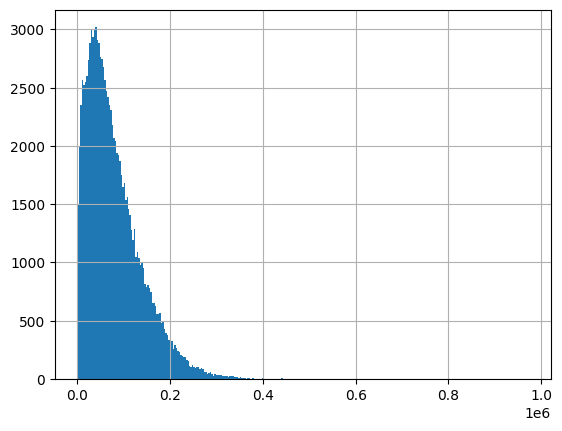

In [11]:
client_behave_trace.duration.hist(bins="auto")
plt.show()

The subsequent distribution should show us how different the activity cycles recorded in the traces are. Due to the considerable variation in finish times, it was necessary to use the `finish_time` as a normalisation factor above to simulate devices operating in the same period.


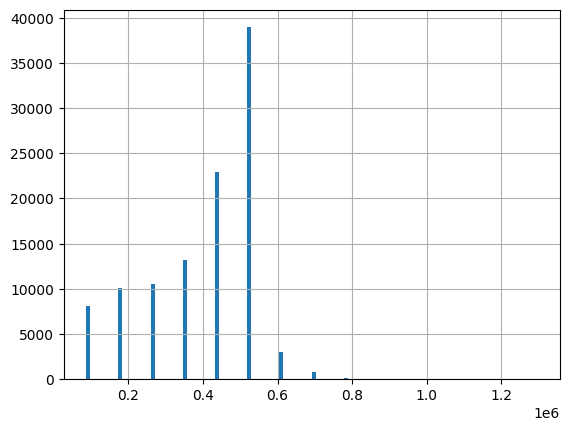

In [12]:
client_behave_trace.finish_time.hist(bins="auto")
plt.show()

One of the choices we had to make when modelling client activity concerned handling the period between 0 and when a client first becomes active; we can now inspect the motivating factors behind treating that period as inactive.

Our choice was theoretically justifiable and practical given the start-times distribution we see below. The peak around 0 is natural, given that this was when the recording started. However, it may create difficulties during FL simulations as it would allow many clients to be available immediately for the first few rounds. Additionally, as all clients would be right at the beginning of their active period for the first round, it would create a scenario with minimal drop-out rates.

> By treating everyone who starts later than 0 as inactive at the start, we lower the potential bias towards the early rounds that a simulation may have.


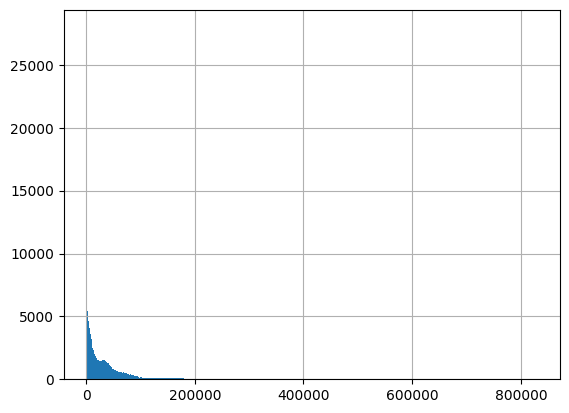

In [13]:
# New column containing the start time of
# each client defined as the beginning
# of their first active period
client_behave_trace["first_active"] = client_behave_trace["active"].map(lambda x: x[0])
client_behave_trace.first_active.hist(bins="auto")
plt.show()

---

**Question 11 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Randomly sample 100 behavioural traces from `client_behave_trace`. Sample without replacement. Plot the total number of active and inactive clients over time for 600000 seconds using steps of 10 seconds.
2. Sort `client_behave_trace` by `finish_time` in **ascending** order. Call it `ft_sorted_client_behave`. Repeat point (1) using `ft_sorted_client_behave` instead of `client_behave_trace`. Replace the random sampling with a sampling of the first 100 traces.
3. Sort `client_behave_trace` by `duration` in **descending** order. Call it `dur_sorted_client_behave`. Repeat point (1) using `dur_sorted_client_behave` instead of `client_behave_trace`. Replace the random sampling with a sampling of the first 100 traces.
4. Compare the three plots. What do you observe? What are the implications of performing FL with such populations?

---

In [48]:
client_behave_trace.head()

,duration,inactive,finish_time,active,model,first_active
1,972262,"[59046, 87718, 161219, 1081886]",1123200,"[51490, 60870, 140727, 164520]",LG-K350,51490
2,691032,"[12823, 658127, 685128, 715053, 765786, 843740...",950400,"[10596, 12885, 683099, 713791, 750327, 834323,...",CPH1909,10596
3,683891,"[109, 4829, 5790, 6531, 7062, 7103, 8804, 9704...",864000,"[36, 112, 5575, 6283, 6905, 7077, 7104, 9233, ...",TA-1028,36
4,666351,"[4085, 6176, 9002, 10072, 450772, 478872, 4818...",950400,"[3266, 5750, 8838, 9382, 11012, 450831, 479288...",SM-A207F,3266
5,597218,"[437679, 437702, 437716, 437778, 437795, 43792...",691200,"[0, 437681, 437703, 437722, 437778, 437798, 43...",RMX1811,0


In [90]:

import math

def plot_number_of_active_clients(df_slice, title=''):
    '''
    Rationale:
    - Whenever a client comes active at time T, the number of active clients
    in bin ceil(T/10)*10 increases by one.

    - ditto inactive at T, ditto decreases by one.

    Compute deltas of the count for all bins 
    Initialise the count to be zero and iterate through all bins, taking a cumulative sum

    That is the number of active clients.
    '''

    
    active_count_deltas = [0 for _ in range(60000)]

    for idx, row in df_slice.iterrows():
        for start_time in row.active:
            bin_idx = math.ceil(start_time / 10)
            if bin_idx < 60000: # Ignore those that overrun 600,000 seconds
                active_count_deltas[bin_idx] += 1

        for end_time in row.inactive:
            bin_idx = math.ceil(end_time / 10)
            if bin_idx < 60000: # Ignore those that overrun 600,000 seconds
                active_count_deltas[bin_idx] -= 1

    active_counts = []
    active_count_tally = 0
    for delta in active_count_deltas:
        active_count_tally += delta
        active_counts.append(active_count_tally)

    inactive_counts = [len(df_slice) - x for x in active_counts]

    plt.figure(figsize=(12, 5))
    plt.plot(active_counts, label='active')  
    plt.plot(inactive_counts, label='inactive')
    plt.legend()
    plt.title(title)
    


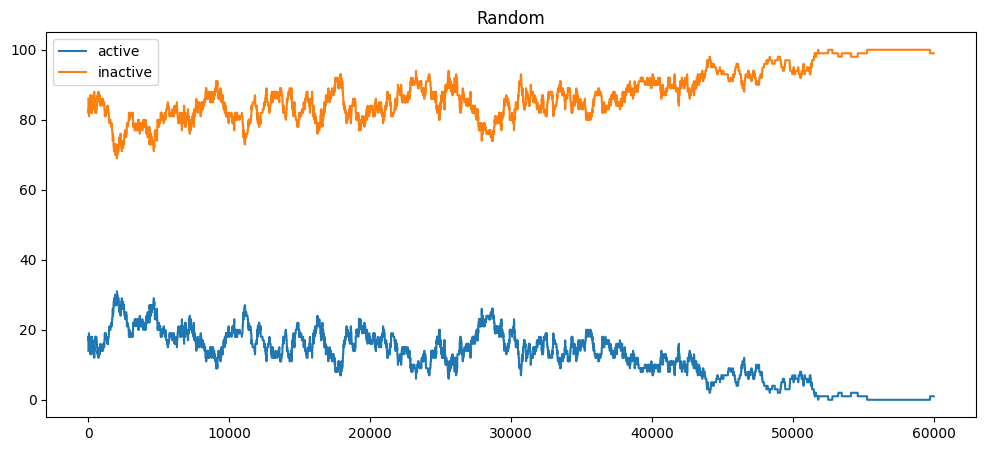

In [91]:
plot_number_of_active_clients(client_behave_trace.sample(100), title='Random')

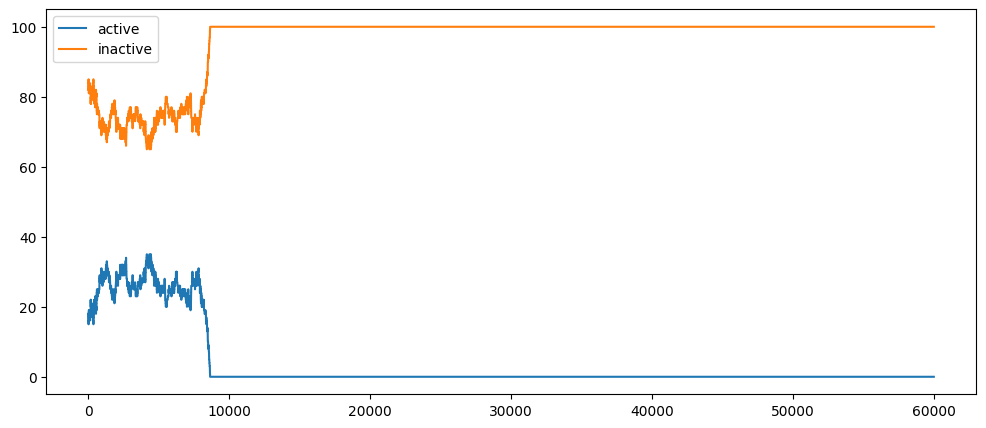

In [92]:
ft_sorted_client_behave = client_behave_trace.sort_values('finish_time')
plot_number_of_active_clients(ft_sorted_client_behave[:100])

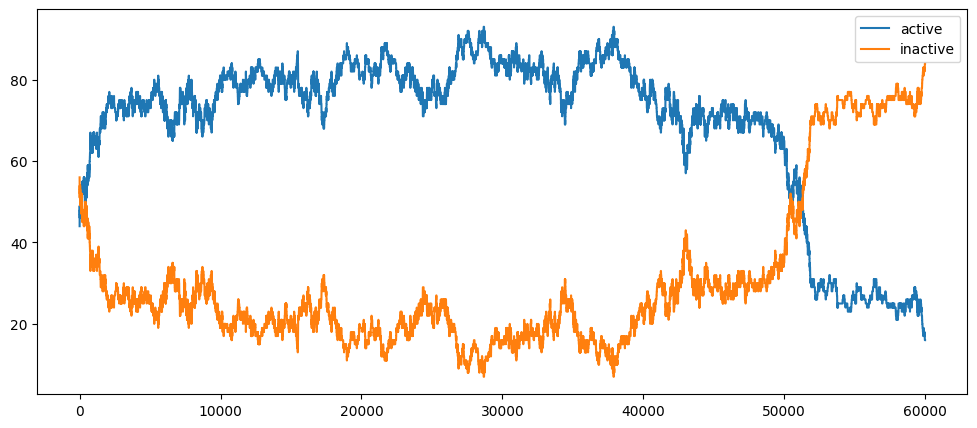

In [93]:
dur_sorted_client_behave = client_behave_trace.sort_values('duration', ascending=False)
plot_number_of_active_clients(dur_sorted_client_behave[:100])


In the random sample, the number of active clients decreases over time while fluctuating around a little, the early finishing clients have a slightly higher count than the random sample in the beginning and then drop off to zero at around 80,000 seconds, and the long duration clients have a significantly higher count than the random sample, which remains high before gradually dropping off at 500,000 seconds. 

Performing FL with such a population means that as we progress further ahead in time and devices start to disconnect, the devices which are going to be available will be the same few very active ones, which might cause our dataset to be more biased.

---

**Question 12 (Part III/MPhil ✅):**

(This is meant to be a conceptual question. You should provide a written answer to this. **No more than 3 sentences each**. **No code** is needed)

1. In light of your consideration about question (5) above, what do you think could happen when reverting the ordering in point (2) and point (3)? Focus on the plots.
2. What are the implications of the FL training with such populations? Refer to populations with reverse ordering in point (2) and point (3).

---

### Analyse what's inside device capabilities
---

In the next few cells, we will analyse the content of `client_device_trace`.
Primarily, we will focus on the distribution of `computation` and `communication` on the clients and the afferent trade-off between the two, given a specific model size.


As we could have imagined, the devices' computational capabilities are highly heterogeneous. For example, despite the consistent peak at around 25 ms/sample, there is a relevant part of the population of devices with values 6 to 8 times higher. Suppose such heterogeneity in computation was related to factors influencing the data distribution. In that case, it could induce significant bias in the model training procedure, which would have to be considered by the developer.


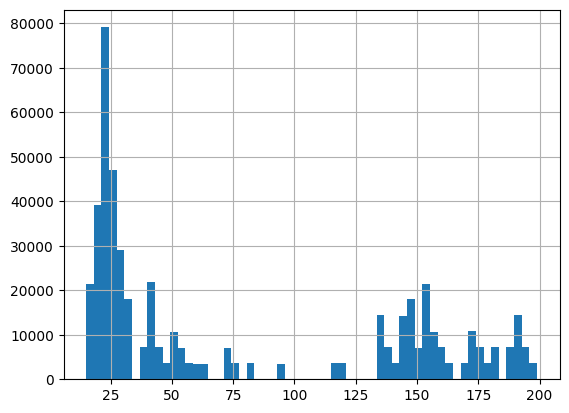

In [95]:
client_device_capacity.computation.hist(bins="auto")
plt.show()

The communication capabilities are also very heterogeneous, as expected. Despite the distribution having a more apparent peak with a shorter tail, some devices have communication capabilities orders of magnitude higher than the peak of the distribution.

Geographic variance in network speed is non-uniform and related to the data a given client may contain.


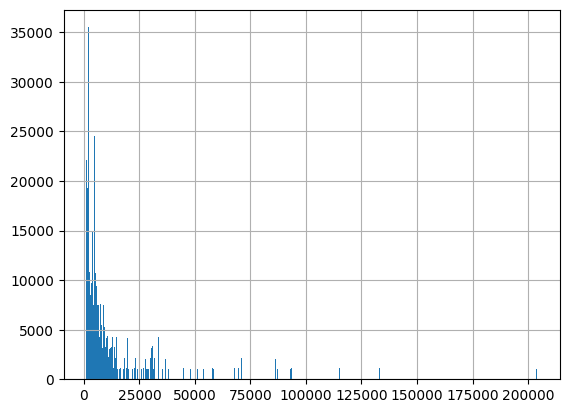

In [96]:
client_device_capacity.communication.hist(bins="auto")
plt.show()

In [97]:
client_device_capacity.communication.mean()

13736.140238980068

As you may have previously noticed, the traces for the device compute capabilities and the traces for availability are uncorrelated. This is due to a lack of datasets in FL which synchronously cover both.

In the following question you will be asked to numerically verify this lack of correlation. 

---

**Question 13 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Looking carefully at the number in the y-axis, some of you may have noticed that the number of samples retrieved from `client_behave_trace` is not the same as that retrieved from `client_device_capacity`. Given this fact, we may wish to investigate if they are drawn from the same population of devices.

1. Plot communication and computation mapped one-to-one using the entirety of `client_device_capacity`.

- Do you notice any correlation between the two traces as given?

2. Fix two different thresholds for computation, and plot the histogram of communication costs from the previous mapping using only traces whose computation falls below the given threshold.

- Do these histograms look different from one another?
- Do they look different from the overall communication histogram?

3. Fix two communication thresholds and plot the histograms of computation costs of traces with communication values falling below the thresholds.

- Do these histograms look different from one another?
- Do they look different from the overall computation histogram?

---

Text(0.5, 0, 'computation')

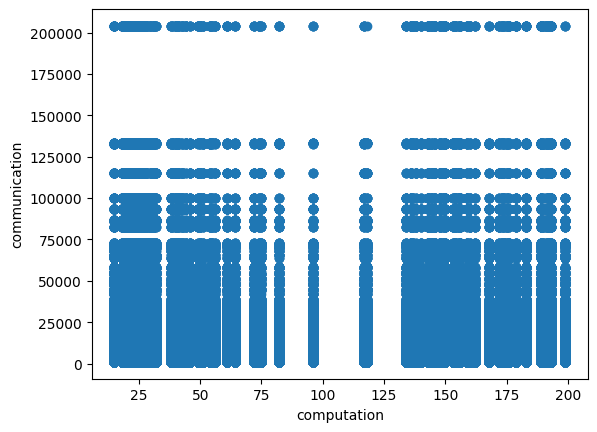

In [104]:
plt.scatter(x=client_device_capacity['computation'], 
            y=client_device_capacity['communication'])
plt.ylabel('communication')
plt.xlabel('computation')

In [ ]:
COMMUNICATION_THRESHOLD_1 = 10000
COMMUNICATION_THRESHOLD_2 = 100000

COMPUTATION_THRESHOLD_1 = 20
COMPUTATION_THRESHOLD_2 = 100

client_device_capacity['communication'] < 

There is no obvious correlation between computation and communication.

The mismatch between the two types of traces is because the authors of FedScale have combined two separate datasets to construct the files. They used [AI benchmark](https://arxiv.org/abs/1910.06663) to obtain the performance capabilities of mobile devices and [MobiPerf](https://www.measurementlab.net/tests/mobiperf/) to gather the availability traces.

Similarly to the mismatch between traces and data we have previously discussed, experiments using performance and availability traces collected from separate devices may not generalise to the real world. However, since we do not yet have the large-scale datasets necessary to model FL systems accurately, we will have to accept this inconsistency.


In [ ]:
log(
    INFO,
    "The number of samples in `client_behave_trace` is %s",
    len(client_behave_trace),
)
log(
    INFO,
    "The number of samples in `client_device_capacity` is %s",
    len(client_device_capacity),
)

Because the clients do not come from the same population, we need to devise a method for synchronising them.
The most straightforward procedure we can devise is to sample `len (client_behave_trace)` data points from `client_device_capacity` uniformly. Many other methods that can extract distributions with particular characteristics are possible, but we will do this for brevity.


In [ ]:
client_device_capacity = client_device_capacity.sample(
    len(client_behave_trace), replace=False, random_state=Seeds.DEFAULT
)
log(
    INFO,
    "The `client_device_capacity` obtained is %s",
    client_device_capacity,
)

We can plot the distributions from `client_device_capacity` to see if the sampling procedure has succeeded before we apply it in our experiments.


In [ ]:
client_device_capacity.computation.hist(bins="auto")
plt.show()
client_device_capacity.communication.hist(bins="auto")
plt.show()

For later experiments, you will have to use a computation threshold to select clients. The following plot is likely the most revealing if you wish to understand better the impact a particular computation threshold will have on the number of clients that may be included in a given round. Pay particular attention to the sharp increase at the start of the plot.


In [ ]:
client_device_capacity.computation.hist(bins="auto", cumulative=True, density=True)
plt.show()

---

**Question 14 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

We have just extracted and analysed the device capabilities of our population and obtained some idea about how communication and computation capabilities are distributed. However, the exact trade-off depends on `model_size`, `batch_size` and `n_batches`. Since `batch_size*n_batches` is fixed to equal the local dataset size, `model_size` requires closer attention for our modelling of FL systems to be informative. Specifically, we want both communication and computation to have detectable impacts on your FL experiments and their interaction shifts as you scale a network.

Our function `get_client_completion_time` can help us observe the trade-off between computation and communication without running costly FL experiments. For the following question, assume that `batch_size=32`, `n_batches=64` stay fixed.

1. Compute the average client completion time for different values of `model_size`. The average is intended to be over the population described by `client_device_capacity`. Choose at least 100 different values of the `model_size` in the interval `[0,2000] MB`.
2. Plot your results from (1) as explained here: from (1) you will have the average communication latency (`a`), the average computation latency (`b`), and you can compute their sum (`c`). Then, plot those three curves (`a`, `b`, and `c`) in the same graph VS model size. The intersection point between `a` and `b` must be visible. What does it represent?
3. Extract the model size from the intersection point in (2).

---

## 4. Implementing system traces in the simulation
---

To implement our system traces into the Flower simulator to model a real FL federation, we need to extend the abstraction of `FlowerRayClient`. The new version of the abstraction shall include the information we have extracted from the traces. Achieving this will require creating a new class `FlowerRayClientTraces`, which inherits from `FlowerRayClient`.

The new class will have minimal new attributes and functions needed to model the actual system accurately. We will simulate clients dropping out of the federation by throwing exceptions and allowing Flower to accept failures.

The `get_flower_client_generator` function will be modified to return a generator of `FlowerRayClientTraces` instead of `FlowerRayClient`. In addition, we will pass the traces that must be coupled to the clients as parameters.


### Implementation
---

We will also use previously unrevealed Flower features, such as client properties and criteria, so pay attention to those details. In short, clients can return properties to a criterion after they have been instantiated. The criterion then decides if the client should be included in the next federated round based on those properties.


In [ ]:
class FlowerClientTraces(FlowerClient):
    """Extend the FlowerClient class to include traces and device capabilities."""

    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
        single_client_device_capacity: dict[str, Any],
        single_client_traces: dict[str, Any],
        verbose: bool = False,
    ) -> None:
        """Initialise the client.

        A Client is given a unique id and the directory from which it can load its data.
        Device capabilities and traces are also passed to the client.

        Parameters
        ----------
            data_dir (Path): path to the dataset folder.
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each client/client
                id
            model_generator (Callable[[], Module]): The model generator function
            single_client_device_capacity (dict[str, Any]): dictionary containing info
                about device capabilities.
            single_client_traces (dict[str, Any]): dictionary describing client device
                traces.
            verbose (bool): boolean describing whether the client should print or not.
        """
        super().__init__(cid, partition_dir, model_generator, data_dir)
        self.device_capacity = single_client_device_capacity
        self.trace = single_client_traces
        self.verbose = verbose
        self.properties: dict[str, Any] = {
            "tensor_type": "numpy.ndarray",
            "cid": self.cid,
            "device_capacity": self.device_capacity,
            "traces": self.trace,
        }

    def fit(
        self, parameters: NDArrays, config: dict[str, Scalar], **kwargs: dict[str, Any]
    ) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data.

        Also, the function checks if the client is active at the current time step.

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns
        -------
            tuple[NDArrays, int, dict]: Returns the updated model, the size of the
            raise ModelSizeNotFoundError()
        """
        # We need to include model size to compute communications costs as part of our
        # systems-aware simulation. Importantly, since Flower now accepts failures this
        # will only cause the client to return a failure
        if "model_size" not in config:
            raise ModelSizeNotFoundError("Model size not found in config")

        # We need to compute the number of samples in the training set
        # As such we set n_batches to the number of batches which the set contains
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config["batch_size"]),
            n_batches=int(
                int(config["epochs"])
                * self.get_train_set_size()
                / int(config["batch_size"])
            ),
            model_size=float(config["model_size"]),
        )
        # Add up the communication and computation times
        total_time = completion_time["communication"] + completion_time["computation"]

        # Store the result in the trace
        self.trace["duration"] = total_time

        if self.verbose:
            log(
                INFO,
                "Client %s\n--------\n\t\t"
                "Current virtual clock time: %s\n\t\t"
                "Duration: %s\n\t\t"
                "Traces: %s\n\t\t"
                "Predicted completion: %s\n\t\t"
                "Active: %s\n--------\n",
                self.cid,
                config["current_virtual_clock"],
                total_time,
                self.trace,
                int(config["current_virtual_clock"]) + int(total_time),
                is_active(
                    self.trace, int(config["current_virtual_clock"]) + int(total_time)
                ),
            )
        if "current_virtual_clock" not in config:
            raise IntentionalDropoutError("Current virtual clock not found in config")
        if not is_active(
            self.trace, int(config["current_virtual_clock"]) + int(total_time)
        ):
            raise IntentionalDropoutError(
                f"Client {self.cid} is not active at the current time step"
            )

        n_samples = len(self._create_data_loader(config, "train"))

        # NOTE: We do not need to train for this experiments
        # params, n_samples, results = super().fit(parameters, config)
        results = {
            "client_completion_time": total_time,
            "computation": self.device_capacity["computation"],
            "communication": self.device_capacity["communication"],
            "num_samples": n_samples,
            "cid": self.cid,
        }

        return parameters, n_samples, results

    def evaluate(
        self, parameters: NDArrays, config: dict[str, Scalar], **kwargs: dict[str, Any]
    ) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data.

        Also, the function checks if the client is active at the current time step.

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the testing parameters

        Returns
        -------
            tuple[float, int, dict]: Returns the loss accumulate during testing, the
                size of the local dataset and other metrics such as accuracy
        """
        if "model_size" not in config:
            raise ModelSizeNotFoundError("Model size not found in config")

        # Estimate time based on number of batches in dataset
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config["batch_size"]),
            n_batches=int(self.get_test_set_size() / int(config["batch_size"])),
            model_size=float(config["model_size"]),
        )

        # Compute total time
        total_time = completion_time["communication"] + completion_time["computation"]

        # Store result in trace
        self.trace["duration"] = total_time
        if self.verbose:
            log(
                INFO,
                "Client %s\n--------\n\t\t"
                "Current virtual clock time: %s\n\t\t"
                "Duration: %s\n\t\t"
                "Traces: %s\n\t\t"
                "Predicted completion: %s\n\t\t"
                "Active: %s\n--------\n",
                self.cid,
                config["current_virtual_clock"],
                total_time,
                self.trace,
                int(config["current_virtual_clock"]) + int(total_time),
                is_active(
                    self.trace, int(config["current_virtual_clock"]) + int(total_time)
                ),
            )
        if "current_virtual_clock" not in config:
            raise IntentionalDropoutError("Current virtual clock not found in config")
        if not is_active(
            self.trace, int(config["current_virtual_clock"]) + int(total_time)
        ):
            raise IntentionalDropoutError(
                f"Client {self.cid} is not active at the current time step"
            )

        n_samples = len(self._create_data_loader(config, "test"))

        # NOTE: We do not need to train for this experiments
        # params, n_samples, results = super().fit(parameters, config)
        results = {
            "client_completion_time": total_time,
            "computation": self.device_capacity["computation"],
            "communication": self.device_capacity["communication"],
            "num_samples": n_samples,
            "cid": self.cid,
        }

        return 0.0, n_samples, results

In [ ]:
def get_flower_client_with_traces_generator(
    clients_device_capacity: list[dict[str, Any]],
    clients_traces: list[dict[str, Any]],
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerClient]:
    """Wrap the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Parameters
    ----------
        clients_device_capacity (list[dict[str, Any]]): list containing the clients
            device capabilities.
        clients_traces (list[dict[str, Any]]): list containing the clients traces.
        data_dir (Path): path to the datasßet folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Callable[[int], int] | None): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClientTraces:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            FlowerRayClientTraces: client instance.
        """
        log(INFO, "Getting client with id %s", cid)
        client = FlowerClientTraces(
            # NOTE: passing the called `cid` here to allow for different mapping between
            # data and devices
            single_client_device_capacity=clients_device_capacity[int(cid)],
            single_client_traces=clients_traces[int(cid)],
            # NOTE: the mapping is only applied here, this is due to control the data
            # mapping
            cid=(mapping_fn(int(cid)) if mapping_fn is not None else int(cid)),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
            # NOTE: you may want to comment out the following line or to set the
            # verbosity to False
            verbose=False,
        )

        client.device = get_device()
        return client

    return client_fn

(c) 2025 Alexandru-Andrei Iacob, Lorenzo Sani